In chapter 3, the author dives into three introductory examples of how to use neural networks to address real problems:
1. Classifyng movie reviews as positive or negative (binary classification);
2. Classifying news wires by topic (multiclass classification);
3. Estimating the price of a house, given real-estate data (regression).

### A binary classification example 

##### The IMDB dataset

We'll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Dataset. They're split into 25,000 reviews for testing, each set cosisting of 50% negative and 50% positive reviews.
The IMDB comes packaged with Keras. It has already been preprocessed.

In [48]:
# Loading the IMDB dataset
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000) #The arguments num_words=10000 means you'll only keep the top 10,000 most frequently occurring words in the training data.

##### Preparing the data

The variables train_data and test_data are lists of reviews. Train_labels and test_labels are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive.

In [49]:
print(train_data)
print(train_data.shape)
print(train_data.ndim)

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

In [50]:
print(train_labels)
print(train_labels.shape)
print(train_labels.ndim)

[1 0 0 ... 0 1 0]
(25000,)
1


You can't feed lists of integers into a neural network. You have to turn your lists into tensor. There are two ways to do that:
- Pad your list so they all have the same lenght, turn them into an integer tensor of shape (sample, word_indices), and than use as the first layes in your network a layer capable of handling such integer tensors (the Embedding layer)
- One-hot encode your lists to turn them into vectors of 0s and 1s. This wuold mean, for instance, turnng the sequences [3, 5] into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then you could use as the first layer in your network a Danse layer, capable of handling floating-point vector data.

Let's go with the latter solution to vectorize the data, which we'll do manually for maximum clarity.

In [51]:
# Encoding the integer sequences nto a binary matrix
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) #Creates an all-zero matrix of shape (len(sequences), dimension)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. #Sets specific indices of results[i] to 1s
    return results

x_train = vectorize_sequences(train_data) #Vectorized training data
x_test = vectorize_sequences(test_data) #Vectorized test data

In [52]:
print(x_train)
print(x_train.shape)
print(x_train.ndim)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
(25000, 10000)
2


In [53]:
# We should also vectorize the labels
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [54]:
print(y_train)
print(y_train.shape)
print(y_train.ndim)

[1. 0. 0. ... 0. 1. 0.]
(25000,)
1


##### Building the network

The input data is vectors, and the labels are scalar(1s and 0s).
A type of network that performs well on such a problem is a simple stack of fully connected (Dense) layers with relu activation: Dense(16, activation="relu").
- The argument being passed to each Dense layers (16) is the number of hidden units. A hidden unit is a dimension in the rapresentation space of the layer. 
- Each such Dense layer with relu activation implements the following chain of tensor operation: output = relu(dot(W, input)+b)

Having 16 hidden units means the weight matrix will have shape (input_dimension, 16).

Having more hidder units allows your network to learn more complex representations, but it makes the network more computationally expensive and may lead to learning unwanted patterns. 

In [55]:
# The model definition
from keras import models 
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation= "relu", input_shape= (10000,)))
model.add(layers.Dense(16, activation= "relu"))
model.add(layers.Dense(1, activation= "sigmoid"))

Finally, we need to choose a loss function and an optimizer. Because we're facing a binary classification problem and the output of our nework is a probability, it's best to use the binary_crossentropy loss.
Crossentropy is a quantity from the field of Information Theory that measures the distance between probability distribution or, in this case, between the ground-truth distribution and yours predictions. 

In [56]:
# Compiling the model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accurancy"])

Sometimes we may want to configure the parameters of our optimizer or pass a custom loss function or metric function.

In [57]:
# Configuring the optimizer 
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [58]:
# Using custom losses and metrics
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["metrics.binary_accurancy"])

##### Validating the approach

In order to monitor during training the accurancy of the model on data it has never seen before, we'll create a validation set by setting apart 10,000 samples from the original training data.

In [59]:
# Setting aside a validation set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We'll now train the model for 20 epochs (20 interation over all samples in the x_train and y_train tensors) in mini-batches of 512 samples.

For better clarity on what batches and epochs are, here's an example of a model with 2 epochs and 10 batches:
- Epoch 1: Batch 1 → Batch 2 → ... → Batch 10 → Fine Epoch 1
- Epoch 2: Batch 1 → Batch 2 → ... → Batch 10 → Fine Epoch 2

In [60]:
# Training the model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["acc"])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs= 20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - acc: 0.6628 - loss: 0.6250 - val_acc: 0.8621 - val_loss: 0.4466
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - acc: 0.8863 - loss: 0.3852 - val_acc: 0.8804 - val_loss: 0.3416
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - acc: 0.9180 - loss: 0.2756 - val_acc: 0.8880 - val_loss: 0.2936
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - acc: 0.9283 - loss: 0.2198 - val_acc: 0.8873 - val_loss: 0.2796
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - acc: 0.9443 - loss: 0.1785 - val_acc: 0.8905 - val_loss: 0.2743
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - acc: 0.9575 - loss: 0.1478 - val_acc: 0.8870 - val_loss: 0.2799
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - acc: 0.9652 - loss: 0.1241 - val_acc: 0.8842 - val_loss: 0.2901
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - acc: 0.9698 - loss: 0.1064 - val_acc: 0.8790 - val_loss: 0.3096
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - acc: 0.977

Model.fit() returns a History object. This object has a member history, which is a dictionary containing data about everything that happend during training.

In [61]:
# Let's take a look at the History object
history_dict = history.history 
history_dict.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

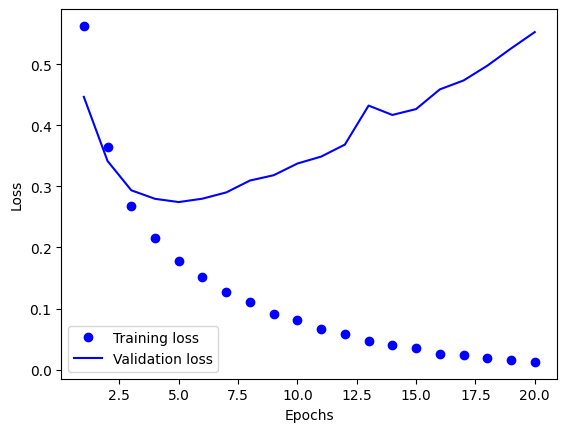

In [63]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

history_dict = history.history 
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(history_dict["acc"])+1)

plt.plot(epochs, loss_values, "bo", label="Training loss") # "bo" is for "blue dot"
plt.plot(epochs, val_loss_values, "b", label="Validation loss") # "b" is for "solid blue line"
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

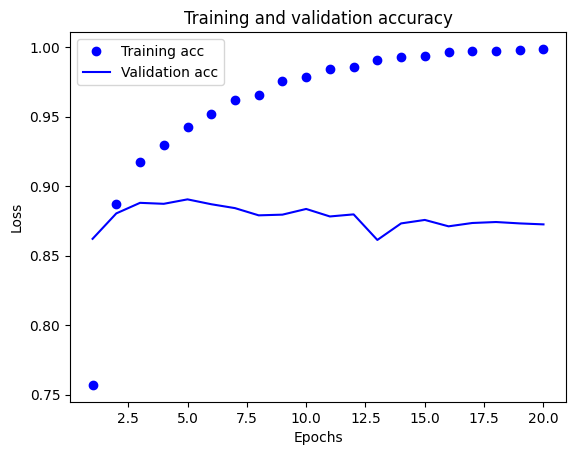

In [64]:
# Plotting the training and validation accurancy 
plt.clf() #Clears the figure
acc = history_dict["acc"]
val_acc = history_dict["val_acc"]

plt.plot(epochs, acc, "bo", label= "Training acc")
plt.plot(epochs, val_acc, "b", label= "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

What you're seeing is overfitting: after the second epoch, we're overoptimizing on the training data and don't generalize the data outside of the training set.

In this case, to prevent overfitting, you could stop training after three epochs. In general, you can use a range of techniques to mitigate overfitting, which we'll cover in chapter 4. 

### A multiclass classification example 

##### The Reuters dataset

We'll work with the Reuters dataset, a set of short newswires and their topics. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.
The Reuters dataset comes packaged as part of Keras.

In [2]:
# Loading the Reuters
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 488s 231us/step


Here's hou you can decode it back to words, in case you're curious

In [4]:
# Decoding newswires back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ''.join([reverse_word_index.get(i-3,'?') for i in train_data[0]])


550378/550378 ━━━━━━━━━━━━━━━━━━━━ 25s 45us/step


##### Preparing the data

Each example is a list of integers (word idices)

In [3]:
print(train_data)

[list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12])
 list([1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12])
 list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4, 78, 13, 68, 467, 511, 110, 59, 89, 90, 67, 139

In [7]:
print(train_labels)

[ 3  4  3 ... 25  3 25]


We can vectorize the data with exact the same code as in the previous example.

In [11]:
# Encoding the data 
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) #Creates an all-zero matrix of shape (len(sequences), dimension)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. #Sets specific indices of results[i] to 1s
    return results

x_train = vectorize_sequences(train_data) #Vectorized training data
x_test = vectorize_sequences(test_data) #Vectorized test data

To vectorize the labels, there are two possibilities: we can either cast the label list as an integer tensor, or use one-hot encoding.
We'll go with the one-hot encoding option.

In [14]:
# Vectorizing the labels using the one-hot encoding method 
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels) #Vectorized training labels
one_hot_test_labels = to_one_hot(test_labels) #Vectorized test labels

Note that there is a built-in way to do this in Keras, which we're already seen in action in the MNIST example.

In [19]:
# Vectorizing the labels using the Keras built-in function
from keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

##### Building the network

The topic-classification problem looks similar to the previous movie-review classification problem: in both case, we're trying to classify short snippets of text. But there is a new constraint here: the numbers of output classes has gone from 2 to 46. The dimensionality of the output is much larger. For this reason we'll use larger layers. Let's go with 64 units.

In [20]:
# Model definition
from keras import models
from keras import layers 

model = models.Sequential()
model.add(layers.Dense(64, activation= "relu", input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

/Users/letizialibrobuono/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The last layer uses a softmax activation. It means the network will output a probability distribution over the 46 different output classes -for every input sample, the network will produce a 46-dimensional output vector, where output[i] is the probability that the sample belongs to class i. 
The 46 scores will sum to 1.

In [21]:
# Compiling the model
model.compile(optimizer= "rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

##### Validating the approach

Let's aparte 1,000 samples in the training data to yse as validation set.

In [22]:
# Setting aside a validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train the network for 20 epochs

In [24]:
# Training the model 
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.4013 - loss: 3.1499 - val_accuracy: 0.5980 - val_loss: 1.8005
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6526 - loss: 1.6358 - val_accuracy: 0.6920 - val_loss: 1.3639
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7272 - loss: 1.2249 - val_accuracy: 0.7240 - val_loss: 1.2228
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7793 - loss: 1.0010 - val_accuracy: 0.7530 - val_loss: 1.1017
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8197 - loss: 0.8375 - val_accuracy: 0.7850 - val_loss: 1.0152
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8533 - loss: 0.6894 - val_accuracy: 0.7880 - val_loss: 0.9780
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8765 - loss: 0.5829 - val_accuracy: 0.8050 - val_loss: 0.9253
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9044 - loss: 0.4608 - val_accuracy: 0.8060 - 

And finally, let's display its loss and accuracy curves.

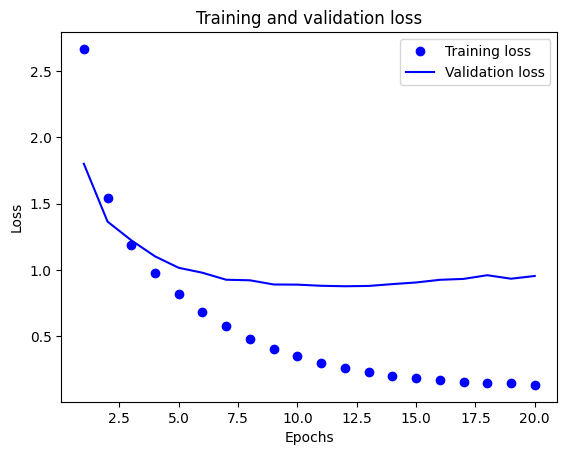

In [27]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

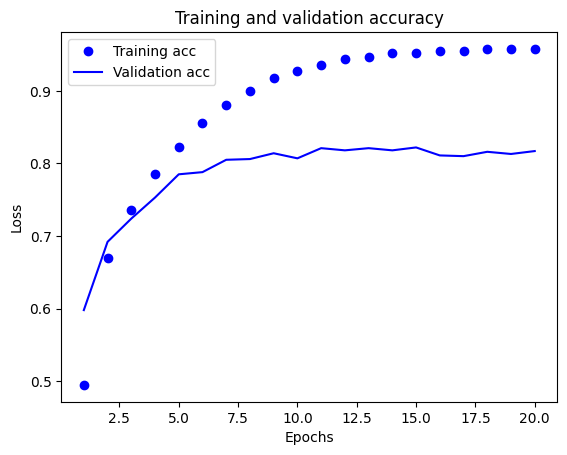

In [29]:
# Plotting the training and validation accuracy 
plt.clf() #Clears the figure

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


##### Evaluating the network on the test set

The network begins to overfit after nine epochs. Let's train a new network from scrach for nine epochs and the evaluate it on the test set.

In [31]:
# Retraining a model from scratch
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

print(results)

/Users/letizialibrobuono/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4079 - loss: 3.1741 - val_accuracy: 0.6320 - val_loss: 1.8860
Epoch 2/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6655 - loss: 1.6722 - val_accuracy: 0.7040 - val_loss: 1.4269
Epoch 3/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7315 - loss: 1.2349 - val_accuracy: 0.7390 - val_loss: 1.2201
Epoch 4/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7896 - loss: 0.9934 - val_accuracy: 0.7560 - val_loss: 1.1007
Epoch 5/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8233 - loss: 0.8407 - val_accuracy: 0.7840 - val_loss: 1.0126
Epoch 6/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8611 - loss: 0.6795 - val_accuracy: 0.7890 - val_loss: 0.9737
Epoch 7/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8788 - loss: 0.5801 - val_accuracy: 0.8070 - val_loss: 0.9124
Epoch 8/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9069 - loss: 0.4740 - val_accuracy: 0.8140 - val_loss:

In [33]:
# Comparing the results obtained with a random baseline
import copy 
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.18699910952804988

The results obtained with the network seem pretty good compared to the random baseline.

### A regression example 

We'll attempt to predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on.

##### The Boston Housing Price dataset

The dataset we'll use has relatively few data points: only 506, split between 404 training samples and 102 test samples. And each feature in the input data (for example, the crime rate) has different scale. For instance, some values are proportion, which take values between 0 and 1; other take values between 1 and 12m other between 0 and 100, and so on. 

In [1]:
# Loading the Boston housing dataset
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

2024-09-16 19:00:36.456626: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/letizialibrobuono/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


##### Preparing the data

In [2]:
print(train_data)
print(train_targets)

[[1.23247e+00 0.00000e+00 8.14000e+00 ... 2.10000e+01 3.96900e+02
  1.87200e+01]
 [2.17700e-02 8.25000e+01 2.03000e+00 ... 1.47000e+01 3.95380e+02
  3.11000e+00]
 [4.89822e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.75520e+02
  3.26000e+00]
 ...
 [3.46600e-02 3.50000e+01 6.06000e+00 ... 1.69000e+01 3.62250e+02
  7.83000e+00]
 [2.14918e+00 0.00000e+00 1.95800e+01 ... 1.47000e+01 2.61950e+02
  1.57900e+01]
 [1.43900e-02 6.00000e+01 2.93000e+00 ... 1.56000e+01 3.76700e+02
  4.38000e+00]]
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46

It would be problematic to feed into a neural network values that all take widly different ranges.
A widespread beat practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we substract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation.

In [3]:
# Normalizing the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

##### Building the network

Because so few samples ara available, we'll use a very small network with two hidden layers, each with 64 units.

In [4]:
from keras import models 
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(1))

    model.compile(optimizer="rmsprop",
                  loss="mse",
                  metrics=["mae"])
    
    return model

Note that we compile the network with the mse loss function -mean squared error (MSE), the square of the difference between the predictions and the target. This is widely used function for regression problem. We're also monitoring a new metric during training: mean absolute error (MAE). It's the absolute value of the difference between the predictions and the targets. 

##### Validating the approach using K-fold validation

The K-fold cross-validation consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaning partition.
The validation scores for the model used is then the average of the K validation scores obtained.

In [5]:
# K-fold validation 
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print("processing fold #', i") 
    val_data = train_data[i*num_val_samples: (i+1)* num_val_samples] #Prepares the validation data: data from partition #k
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]

    partial_train_data = np.concatenate( #Prepares the training data: data from all other partitions
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],
         axis=0
    )

    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
         axis=0
    )

    model = build_model() #Builds the Keras model (already compiled)
    model.fit(partial_train_data, partial_train_targets, #Trains the model (in silent mode, verbose = 0)
              epochs=num_epochs, batch_size=1, verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) #Evaluates the model on the validation data
    all_scores.append(val_mae)

processing fold #', i


/Users/letizialibrobuono/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold #', i
processing fold #', i
processing fold #', i


Running this with num_epochs = 100 yields the following results:

In [6]:
print(all_scores)
print(np.mean(all_scores))

[1.9673452377319336, 2.2996764183044434, 2.5622856616973877, 2.226466417312622]
2.2639434337615967


Let’s try training the model a bit longer: 500 epochs. To keep a record of how well the model does at each epoch, we’ll modify the training loop to save the per-epoch validation score log for each fold.

In [7]:
# Saving the validation logs at each fold
num_epochs = 500 
all_mae_histories = [] 
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] #Prepares the validation data: data from partition #k
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples] 
    
    partial_train_data = np.concatenate( #Prepares the training data: data from all other partitions
        [train_data[:i * num_val_samples], 
         train_data[(i + 1) * num_val_samples:]], 
         axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], 
         train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model() #Builds the Keras model (already compiled)
    history = model.fit(partial_train_data, partial_train_targets, #Trains the model (in silent mode, verbose=0)
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0) 
    
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)


Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


We can then compute the average of the per-epoch MAE scores for all folds.

In [8]:
# Building the history of successive mean K-fold validation scores
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

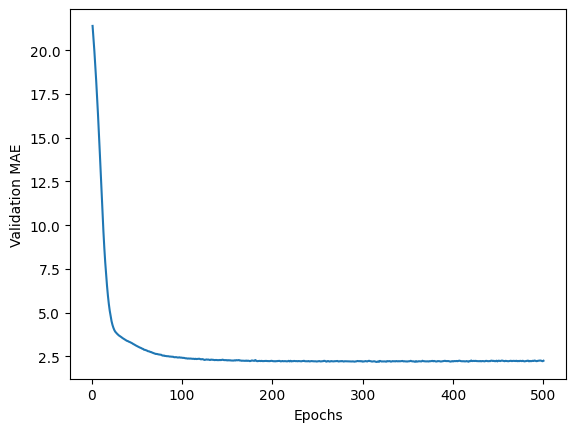

In [10]:
# Plotting validation scores
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [18]:
# Training the final model
model = build_model()
model.fit(train_data, train_targets, 
          epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.7394 - mae: 2.6741  


Here's the final result:

In [19]:
print(test_mae_score)

2.891998529434204
